## Feature Importance Quantification and Selection
This notebook shows methods to quantify machine learning features' importance using Shapley values. Features with high importance are thus selected for further analysis.

In [84]:
import numpy as np
import pandas as pd
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from collections import Counter
import shap

In [97]:

def get_features(clf, frame_info, X_train, X_test):
    """Calculate Shapley values for each feature and select top features.
    Notes
    -----
    For each prediction task, as Shapley value is computed using the SHAP
    package. Top 1000 features were chosen for further analysis.

    Parameters
    ----------
    clf : classifer object
        The trained machine learning classifer
    frame_info : dataframe
        Mapping of the feature indices to genomic region
        Index -> chr, start, end
    X_train : list
        Training samples
    Returns
    -------
    List
        List of indices representing top features
    """

    features = []
    
    # Do SHAP analysis
    
    ## Using following settings for classifiers other than Random Forest
    # explainer = shap.Explainer(clf, X_train)
    # shap_values = explainer(X_test)
    
    explainer = shap.Explainer(clf)
    shap_values = explainer(X_train)

    # visualize the first prediction's explanation
    # shap.plots.beeswarm(shap_values[:,:,0], max_display=15)

    vals = shap_values.values
    vals_abs = np.abs(vals)
    val_mean = np.mean(vals_abs, axis=0)
    val_final = np.mean(val_mean, axis=1) # Comment out for classifiers other than Random Forest
    val_final = val_mean
    indexes = []

    for index in sorted(range(len(val_final)), key=lambda i: abs(val_final[i][0]), reverse=True)[:1000]: # abs(val_final[i]) for classifiers other than Random Forest
        features.append(frame_info.iloc[index]['identifier'])
        indexes.append(index)
    
    return features

In [98]:
def feature_analysis(top_features, frame_info, modality, classifier_name, outfolder):
    """Find the intersection of features across 5-fold cross validation.
    Notes
    -----
    For each fold of cross-validation, a list of features are generated.
    This function finds the intersection of those lists and extract
    stably important features.

    Parameters
    ----------
    top_features : List[List[int]]
        Lists of indices representing top features from 5-fold cross validation
    frame_info : dataframe
        Mapping of the feature indices to genomic region
        Index -> chr, start, end
    modality : str
        Name of the modality
    classifier_name: str
    outfolder: str
        Directory for output
    Returns
    -------
    None
    """

    # Count how many times a feature appear as the top N features in all folds
    feature_counter = Counter([item for sublist in top_features for item in sublist]) 
    
    with open(f"{outfolder}{classifier_name}_{modality}_GREAT_regions.txt", "w") as file:
        for index, freq in feature_counter.most_common(int(len(top_features)/3)):
            row = frame_info.loc[frame_info.identifier==index]
            chrom = list(row.chrom)[0]
            start = list(row.start)[0]
            end = list(row.end)[0]
            file.write(f'{chrom}\t{start}\t{end}\t{index}\n')

In [99]:
def run_crossval(modality, classifier,classifier_name, datafolder, infofolder, outfolder):
    """Run machine learning models and cross-validations.
    Notes
    -----
    This function runs the machine learning model and calls other functions for
    feature evaluation and selection.

    Parameters
    ----------
    modality : str
        Name of the modality
    classifier : List[obj]
        List of classifier object
    classifier_name: str
    datafolder : str
    infofolder : str 
    outfolder : str
    
    Returns
    -------
    None
    """
    y_pred = []
    y_test = []
    top_features = []
    init_frame_info = pd.read_csv(infofolder + modality + '_fold_0' + '_frame_info.csv')
    init_frame_info.rename(columns={'Unnamed: 0':'identifier'}, inplace=True)

    # Run through folds
    for i in range(5):

        # Load data and labels
        df = pd.read_csv(datafolder + modality + '_fold_' + str(i) + '_data_hypo.csv',index_col=0)
        labels = pd.read_csv(infofolder + modality + '_fold_' + str(i) + '_labels.csv',index_col=0)

        frame_info = pd.read_csv(infofolder + modality + '_fold_' + str(i) + '_frame_info.csv')
        frame_info.rename(columns={'Unnamed: 0':'identifier'}, inplace=True )

        # Prep integrated data to ensure consistent indexing
        df = df.transpose()
        df.index.rename('file_accession', inplace=True)
        labels.index.rename('file_accession', inplace=True)
        df = pd.merge(df, labels,left_index=True,right_index=True)

        train = np.argwhere(df['test_data'].to_numpy()==0).flatten()
        test = np.argwhere(df['test_data'].to_numpy()==1).flatten()

        y = df['AD_label'].to_numpy()
        X = df.iloc[:,:-4].to_numpy()

        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        classifier = classifier.fit(X[train], y[train])

        y_pred.append(classifier.predict(X[test].tolist()))
        y_test.append(y[test].tolist())

        # calculate SHAP and rank top features
        features = get_features(classifier, frame_info, X[train], X[test])
        top_features.append(features)

    y_pred = list(itertools.chain(*y_pred))
    y_test = list(itertools.chain(*y_test))

    accuracy = accuracy_score(y_test,y_pred)
    print(modality + ' ' + classifier_name + " accuracy: ", accuracy)

    feature_analysis(top_features, init_frame_info, modality, classifier_name, outfolder)

#### Set Directory to data folders

In [ ]:
# Folder for data in CV-fold split and result plots
# Change to do full genome instead of exome only
datafolder = './cv_data_pvalue_fixed_hypo/'
infofolder = './cv_data_pvalue_fixed/'
outfolder = './Hypo_Hyper_Early_Result_strict/Hypo/'

#### Specify models and hyperparameters
Due to the complexity of SHAP analsis, random forest is separately listed out if being used. Settings in get_features() function should be adjusted accordingly.

In [ ]:
# Set classifiers
SVM = svm.SVC(kernel="linear", probability=False, random_state=1)
RandomForest = RandomForestClassifier(max_features=None)
LogRegL2 = LogisticRegression(penalty='l2',random_state=2,solver='lbfgs',max_iter=1000)
LogRegL1 = LogisticRegression(penalty='l1',random_state=2,solver='liblinear',max_iter=1000)

# classifiers = [SVM,LogRegL2,LogRegL1]
# classifier_names = ['SVM','LogRegL2','LogRegL1']

classifiers = [RandomForest]
classifier_names = ['RandomForest']

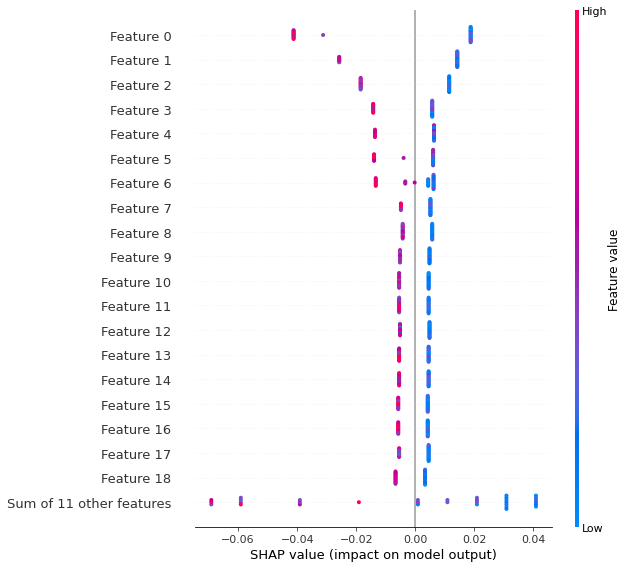

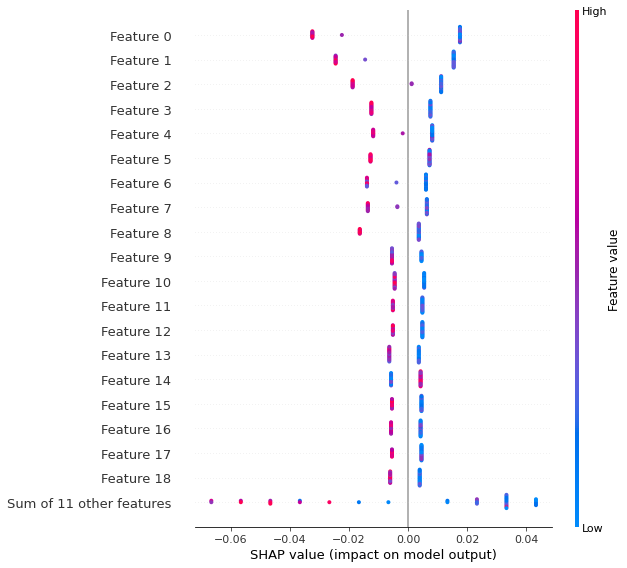

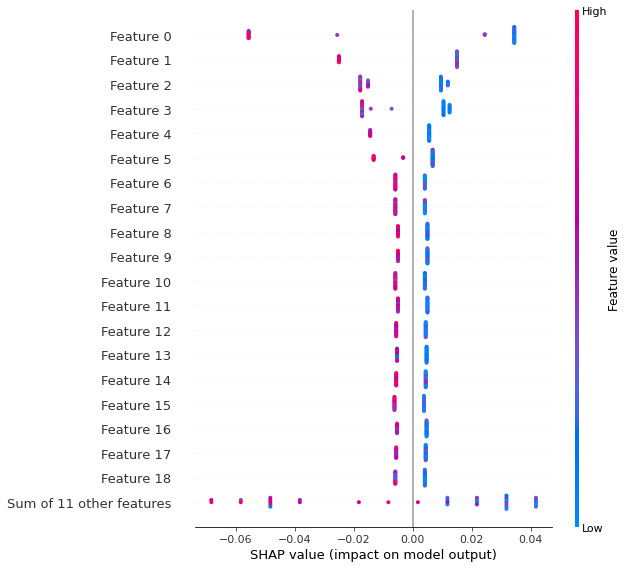

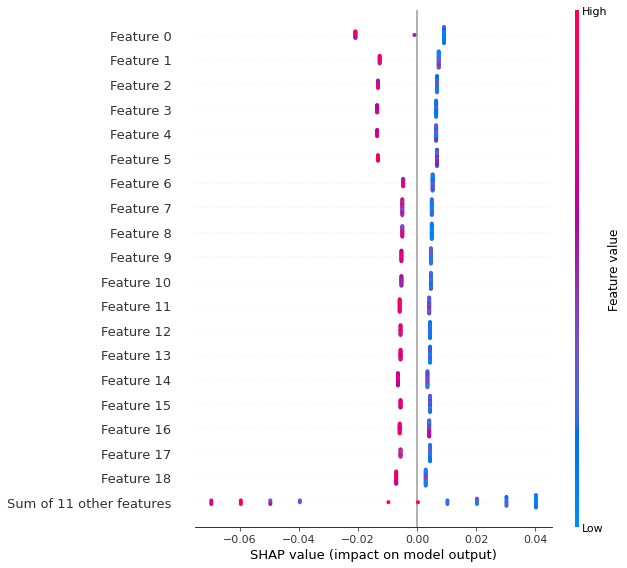

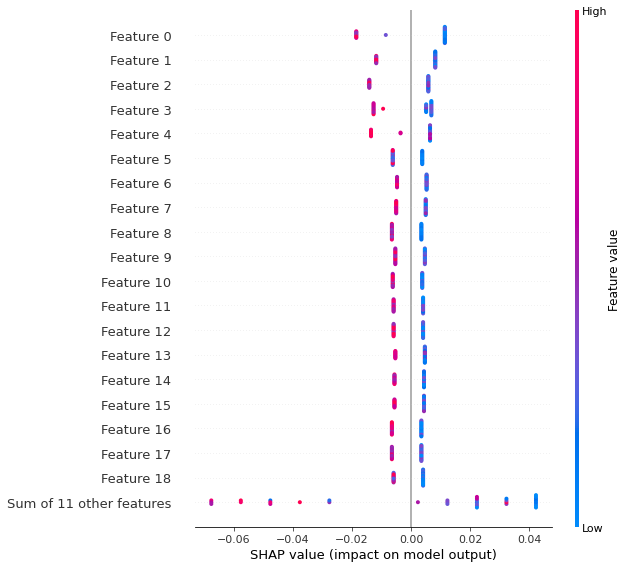

ChIP_H3K4me3 RandomForest accuracy:  0.7142857142857143
Done.


In [100]:
# Set modalities
modalities = ['ChIP_CTCF', 'ChIP_H3K27ac', 'ChIP_H3K27me3', 'ChIP_H3K4me3', 'DNase']

for modality in modalities:
    for i in range(len(classifiers)):
        classifier = classifiers[i]
        classifier_name = classifier_names[i]
        run_crossval(modality, classifier,classifier_name, datafolder, infofolder, outfolder)

print('Done.')